In [2]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize.elementwise import find_root
from sklearn.kernel_ridge import KernelRidge
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import ticker   
import pickle
from tqdm import tqdm
import warnings

In [30]:
# Plots customization

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20

mpl.rcParams['lines.linewidth'] = 3

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['xtick.minor.width'] = 0.8
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.major.pad'] = 5
mpl.rcParams['xtick.minor.pad'] = 4.5

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.minor.width'] = 0.8
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.major.pad'] = 5
mpl.rcParams['ytick.minor.pad'] = 4.5

mpl.rcParams['legend.frameon'] = False

# NFW Profile

$\rho(r) = \frac{\rho_0}{x (1 + x)^2}$ where $x=\frac{r}{R_s}$ and $R_s$ is a scale length.

$M(r) = 4 \pi \rho_0 R_s^3 \left[\ln(1 + \frac{r}{R_s}) - \frac{r}{r + R_s}\right]$

$v_c(r) = \sqrt{\frac{G M(r)}{r}}$

$\phi(r) = \frac{-4 \pi G \rho_0 R_s^3}{r} \ln(1 + \frac{r}{R_s})$

In [31]:
def NFW_rho(r, rho_0, R_s):
    x = r / R_s
    return rho_0 / (x * (1 + x) ** 2)

def NFW_mass(r, rho_0, R_s):
    return 4 * np.pi * rho_0 * R_s ** 3 * (np.log(1 + r / R_s) - r / (r + R_s))

def NFW_circular_velocity(r, rho_0, R_s):
    return (NFW_mass(r, rho_0, R_s) / r) ** 0.5

def NFW_potential(r, rho_0, R_s):
    return -4 * np.pi * rho_0 * R_s ** 3 / r * np.log(1 + r / R_s)

## Virial Radius

The total mass of the the NFW profile diverges at $r \longrightarrow \infty$. It is useful to define the Virial Radius as the upper limit of the extension of the distribution. The ratio between the Virial Radius and the Scale Radius is called the concentration parameter: $c = \frac{R_{vir}}{R_s}$. Typical values of c range from 4 to 40 (https://en.wikipedia.org/wiki/Navarro%E2%80%93Frenk%E2%80%93White_profile).

In [32]:
rho_0 = 1
R_s = 1

c = 25 # Concentration parameter
R_vir = c * R_s # Virial radius

alpha = 10 # Multiplicative factor for plots

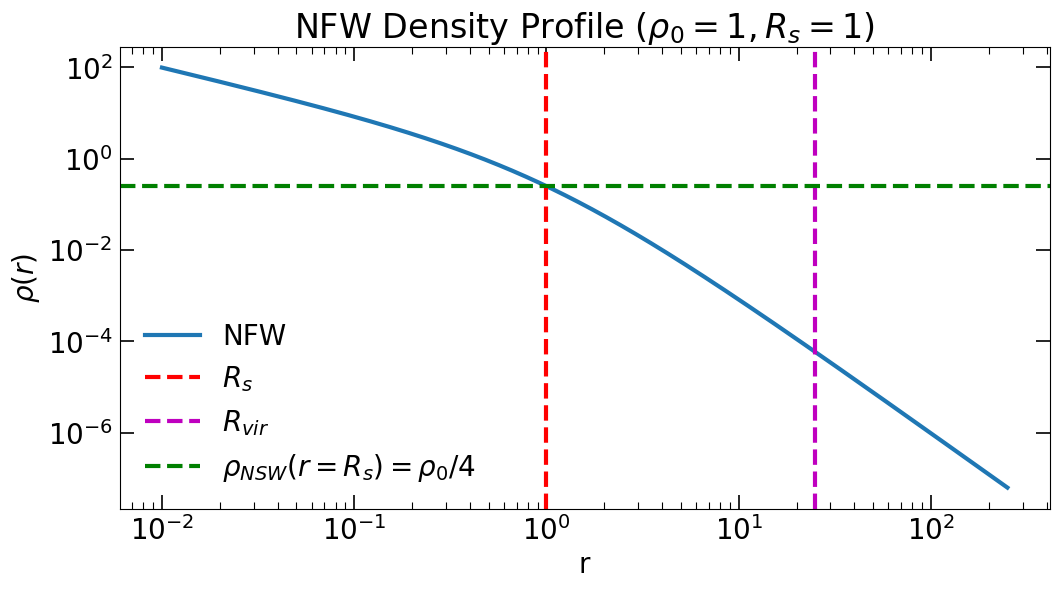

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("NFW Density Profile " + r"($\rho_0 = {0}, R_s = {1}$)".format(rho_0, R_s))
ax.set_xlabel(r"r")
ax.set_ylabel(r"$\rho(r)$")
ax.loglog()

r = np.logspace(-2, np.log10(alpha * R_vir), 10000)
ax.plot(r, NFW_rho(r, rho_0, R_s), label="NFW")
ax.axvline(R_s, color='r', linestyle='--', label=r"$R_s$")
ax.axvline(R_vir, color='m', linestyle='--', label=r"$R_{vir}$")
ax.axhline(rho_0/4, color='g', linestyle='--', label=r"$\rho_{NSW}(r=R_s)=\rho_0/4$")

ax.legend()

plt.show()

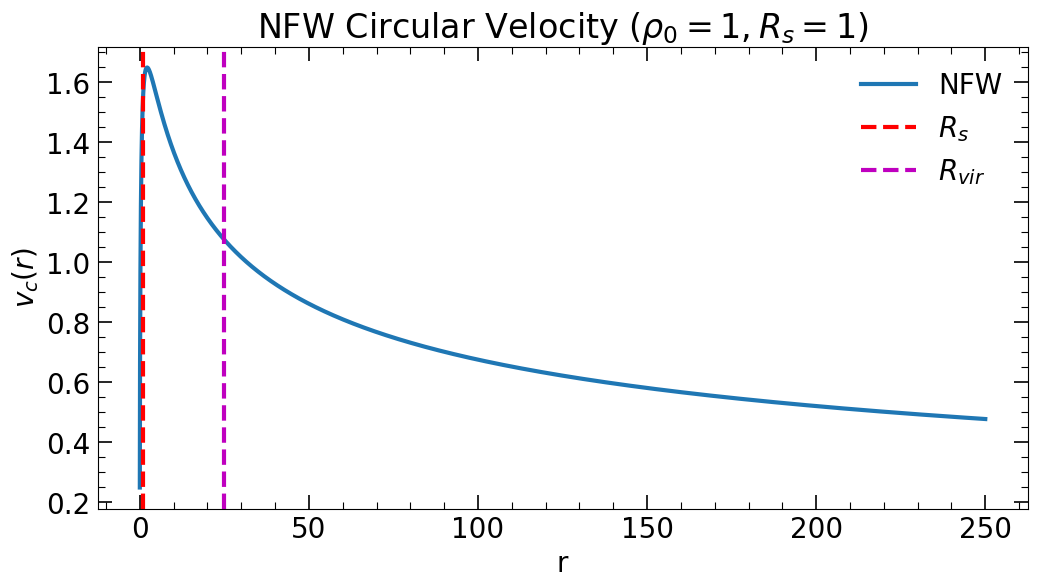

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("NFW Circular Velocity " + r"($\rho_0 = {0}, R_s = {1}$)".format(rho_0, R_s))
ax.set_xlabel(r"r")
ax.set_ylabel(r"$v_c(r)$")

r = np.logspace(-2, np.log10(alpha * R_vir), 10000)
ax.plot(r, NFW_circular_velocity(r, rho_0, R_s), label="NFW")
ax.axvline(R_s, color='r', linestyle='--', label=r"$R_s$")
ax.axvline(R_vir, color='m', linestyle='--', label=r"$R_{vir}$")

ax.legend()

plt.show()

In [35]:
# Functions to compute numerically the primitive of a function.
# The quad based implementation is probably more accurate and also allows
# for integration from -inf or to +inf.

def primitive(func, x_grid, **kwargs):
    return np.array([np.trapezoid(func(x_grid, **kwargs)[:i+1], x_grid[:i+1]) for i in range(len(x_grid))])

def primitive_quad(func, x_grid, *kwargs, lower_limit=None, upper_limit=None):
    if (type(lower_limit) == type(None) and type(upper_limit) == type(None)) or\
        (type(lower_limit) != type(None) and type(upper_limit) != type(None)):
        raise ValueError("Specify limits or use quad directly for integration on fixed intervals")
    if type(upper_limit) != type(None):
        return np.array([quad(func, x_inf, upper_limit, args=kwargs)[0] for x_inf in x_grid])
    elif type(lower_limit) != type(None):
        return np.array([quad(func, lower_limit, x_up, args=kwargs)[0] for x_up in x_grid])

# Modified NFW profiles

In order to avoid a sharp cut of the distribution at the Virial Radius and to have a finite total mass for $r \longrightarrow \infty$, I introduced an additional factor in the original NFW density profile. The first, easy option is to attach an exponential term of the form $\exp(-\frac{r}{R_{vir}})$. This seems to be a valid choice, but the resulting mass circular velocity and potential are quite different from the original NFW ones. Since my goal was to achieve a finite mass while keeping unaltered the other properties of the distribution, in the end I chose a suppression factor of the form $\frac{r}{R_{vir}} \operatorname{csch}(\frac{r}{R_{vir}})$. Another option would have been $\operatorname{sech}(\frac{r}{R_{vir}})$, but the other choice has a more gentle decrease.

The density profile then becomes:

$$\rho(r) = \rho_0 \frac{y \operatorname{csch}(y)}{x (1 + x)^2}$$

where $x = \frac{r}{R_s}$ and $y = \frac{r}{R_{vir}}$. With this choice, the resulting mass, circular velocity and potential are much more similar to the NFW ones, especially at low radii.

The drawback of this choice is that the integrated mass at a given radius, $M(r) = 4 \pi \int_0^r r'^2 \rho(r') dr'$, is not analytic. However the total mass of the system can be written as follows:

$$M_{tot} = 4 \pi \rho_0 R_s^3 \int_0^\infty \left(\frac{x}{c^{-1} + x}\right)^2 \operatorname{csch}(x) dx$$

which is convergent.

Finally, the potential is given by:

$$\phi(r) = -\left[\frac{M(r)}{r} + 4 \pi \int_r^\infty r' \rho(r') dr'\right]$$

In [36]:
def my_rho1(r, rho_0, R_s, R_vir):
    return NFW_rho(r, rho_0, R_s) * np.exp(-r / R_vir)

def my_rho2(r, rho_0, R_s, R_vir):
    x = r / R_vir
    return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)

def my_mass1(r, rho_0, R_s, R_vir, value=False):
    if value:
        return quad(lambda r: (4 * np.pi * r ** 2) * my_rho1(r, rho_0, R_s, R_vir), 0, r)[0]
    else:
        return primitive_quad(lambda r: (4 * np.pi * r ** 2) * my_rho1(r, rho_0, R_s, R_vir),
                              r, lower_limit=0)

def my_mass2(r, rho_0, R_s, R_vir, value=False):
    if value:
        return quad(lambda r: (4 * np.pi * r ** 2) * my_rho2(r, rho_0, R_s, R_vir), 0, r)[0]
    else:
        return primitive_quad(lambda r: (4 * np.pi * r ** 2) * my_rho2(r, rho_0, R_s, R_vir),
                              r, lower_limit=0)

def my_circular_velocity1(r, rho_0, R_s, R_vir, value=False):
    return (my_mass1(r, rho_0, R_s, R_vir, value) / r) ** 0.5

def my_circular_velocity2(r, rho_0, R_s, R_vir, value=False):
    return (my_mass2(r, rho_0, R_s, R_vir, value) / r) ** 0.5

def my_potential1(r, rho_0, R_s, R_vir, value=False):
    if value:
        return -(my_mass1(r, rho_0, R_s, R_vir, value) / r + 4 * np.pi * quad(lambda r: r * my_rho1(r, rho_0, R_s, R_vir),
                                                                              r, np.inf)[0])
    else:
        return -(my_mass1(r, rho_0, R_s, R_vir, value) / r + 4 * np.pi * primitive_quad(lambda r: r * my_rho1(r, rho_0, R_s, R_vir),
                                                                                        r, upper_limit=np.inf))

def my_potential2(r, rho_0, R_s, R_vir, value=False):
    if value:
        return -(my_mass2(r, rho_0, R_s, R_vir, value) / r + 4 * np.pi * quad(lambda r: r * my_rho2(r, rho_0, R_s, R_vir),
                                                                              r, np.inf)[0])
    else:
        return -(my_mass2(r, rho_0, R_s, R_vir, value) / r + 4 * np.pi * primitive_quad(lambda r: r * my_rho2(r, rho_0, R_s, R_vir),
                                                                                        r, upper_limit=np.inf))

In [37]:
dpi = 300

figures = []
figure_names = []

In [38]:
# NFW, exp, csch
linestyles = ['--', '-', '-']
colors = ['gray', 'rosybrown', 'black']
labels = ['NFW', 'exp', 'hyper']

# R_s, R_vir
v_lines_color='dimgray'
v_lines_text = [r'$R_\text{s}$', r'$R_\text{vir}$']
v_lines_styles = [':', '-.']

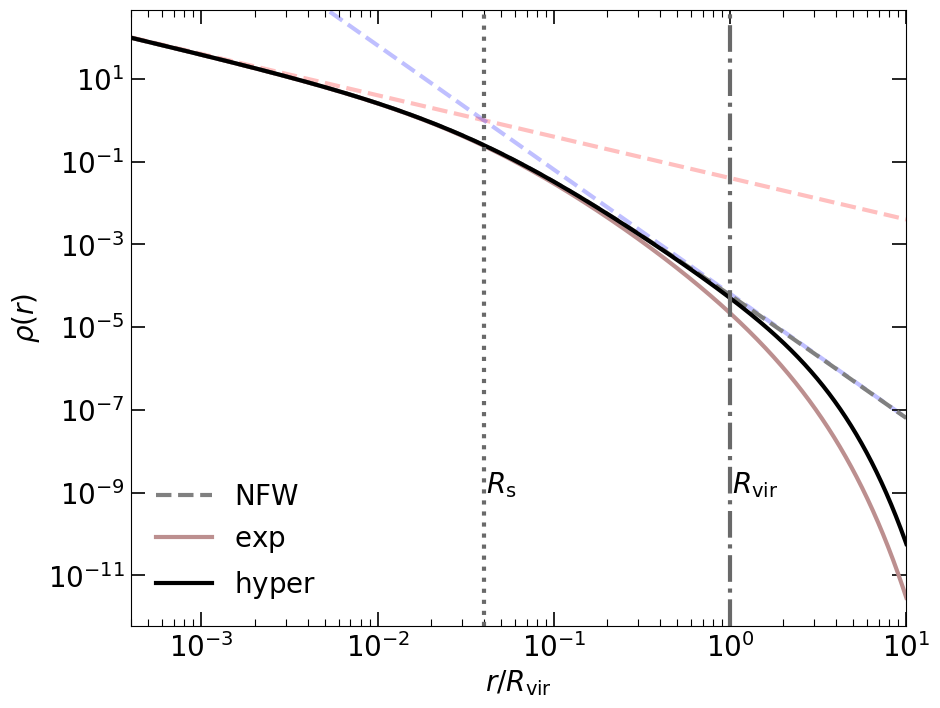

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_xlabel(r"$r/R_\text{vir}$")
ax.set_ylabel(r"$\rho(r)$")
ax.loglog()

r = np.logspace(-2, np.log10(alpha * R_vir), 10000)
rho_NFW = NFW_rho(r, rho_0, R_s)
rho_exp = my_rho1(r, rho_0, R_s, R_vir)
rho_csch = my_rho2(r, rho_0, R_s, R_vir)
slope_1 = r ** -1
slope_3 = r ** -3

for data, ls, c, lbl in zip([rho_NFW, rho_exp, rho_csch], linestyles, colors, labels):
    ax.plot(r / R_vir, data, linestyle=ls, color=c, label=r'$\text{{{0}}}$'.format(lbl))

for val, text, ls in zip(np.array([R_s, R_vir]) / R_vir, v_lines_text, v_lines_styles):
    ax.axvline(val, color=v_lines_color, linestyle=ls)
    ax.text(val * 1.03, 1e-9, text)

ax.legend()

ax.autoscale(axis='x', tight='True')
x_limits = ax.get_xlim()
y_limits = ax.get_ylim()

for data, c in zip([slope_1, slope_3], ['red', 'blue']):
    ax.plot(r / R_vir, data * rho_0, linestyle='--', color=c, zorder=0, alpha=0.25)

ax.set_xlim(x_limits)
ax.set_ylim(y_limits)

figures.append(fig)
figure_names.append('density_comparison')

plt.show()

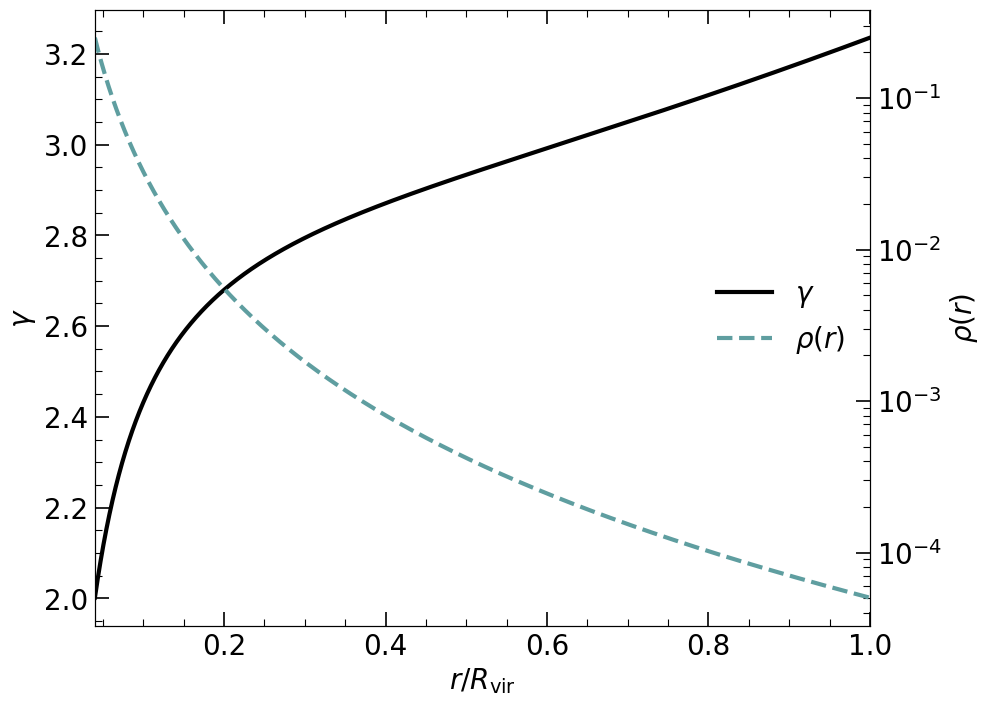

In [40]:
fig, ax1 = plt.subplots(figsize=(10, 8))

ax2 = ax1.twinx()

ax1.set_xlabel(r"$r/R_\text{vir}$")
ax1.set_ylabel(r"$\gamma$")
ax2.set_ylabel(r"$\rho(r)$")

r = np.linspace(R_s, R_vir, 10000)
rho_csch_gamma = my_rho2(r, rho_0, R_s, R_vir)
gamma = -np.gradient(np.log(rho_csch_gamma), np.log(r))

lines = []

lines.append(ax1.plot(r / R_vir, gamma,
                      color='black', label=r'$\gamma$')[0])
lines.append(ax2.plot(r / R_vir, rho_csch_gamma,
                      linestyle='--', color='cadetblue', label=r'$\rho(r)$')[0])

ax2.set_yscale('log')
ax1.autoscale(axis='x', tight='True')

ax1.legend(handles=lines, loc='center right')

figures.append(fig)
figure_names.append('rho_gamma')

plt.show()

/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_92887/1926486665.py:6: RuntimeWarning: overflow encountered in sinh
  return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)


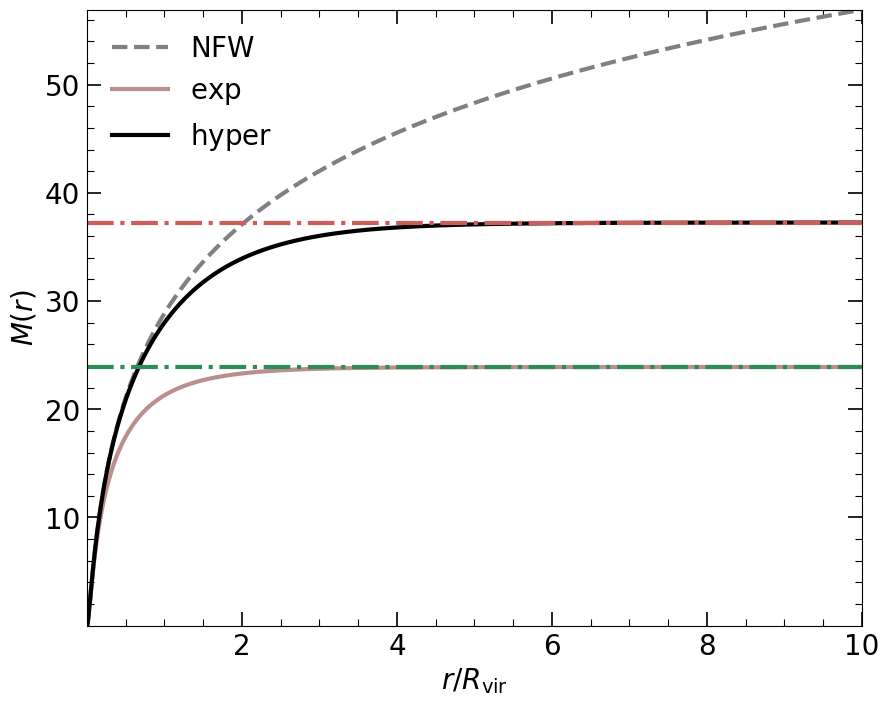

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_xlabel(r"$r/R_\text{vir}$")
ax.set_ylabel(r"$M(r)$")

r = np.logspace(-2, np.log10(alpha * R_vir), 10000)
mass_NFW = NFW_mass(r, rho_0, R_s)
mass_exp = my_mass1(r, rho_0, R_s, R_vir)
mass_csch = my_mass2(r, rho_0, R_s, R_vir)
mass_exp_inf = my_mass1(np.inf, rho_0, R_s, R_vir, value=True)
mass_csch_inf = my_mass2(np.inf, rho_0, R_s, R_vir, value=True)

for data, ls, c, lbl in zip([mass_NFW, mass_exp, mass_csch], linestyles, colors, labels):
    ax.plot(r / R_vir, data, linestyle=ls, color=c, label=r'$\text{{{0}}}$'.format(lbl))

ax.axhline(mass_csch_inf, color='indianred', linestyle='-.')
ax.axhline(mass_exp_inf, color='seagreen', linestyle='-.')

ax.legend()

ax.autoscale(axis='both', tight=True)

figures.append(fig)
figure_names.append('mass_comparison')

plt.show()

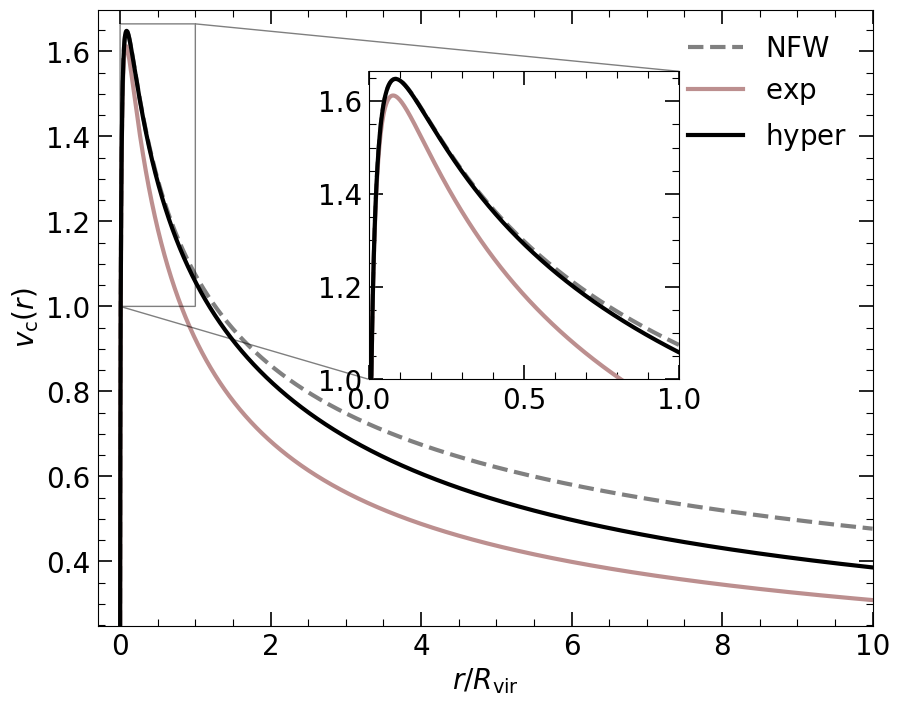

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_xlabel(r"$r/R_\text{vir}$")
ax.set_ylabel(r"$v_\text{c}(r)$")

r = np.logspace(-2, np.log10(alpha * R_vir), 10000)
circular_velocity_NFW = NFW_circular_velocity(r, rho_0, R_s)
circular_velocity_exp = my_circular_velocity1(r, rho_0, R_s, R_vir)
circular_velocity_csch = my_circular_velocity2(r, rho_0, R_s, R_vir)

axins = ax.inset_axes([0.35, 0.4, 0.4, 0.5],
                      xlim=(0, R_vir / R_vir), ylim=(1, np.max(circular_velocity_csch) * 1.01))

for data, ls, c, lbl in zip([circular_velocity_NFW, circular_velocity_exp, circular_velocity_csch], linestyles, colors, labels):
    for _ax in [ax, axins]:
        _ax.plot(r / R_vir, data, linestyle=ls, color=c, label=r'$\text{{{0}}}$'.format(lbl))

ax.indicate_inset_zoom(axins, edgecolor='black')

ax.legend()

ax.autoscale(axis='y', tight=True)
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 1.03)
ax.set_xmargin(0.03)
ax.set_xlim(ax.get_xlim()[0], np.max(r) / R_vir)

figures.append(fig)
figure_names.append('v_circ_comparison')

plt.show()

/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_92887/1926486665.py:6: RuntimeWarning: overflow encountered in sinh
  return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)


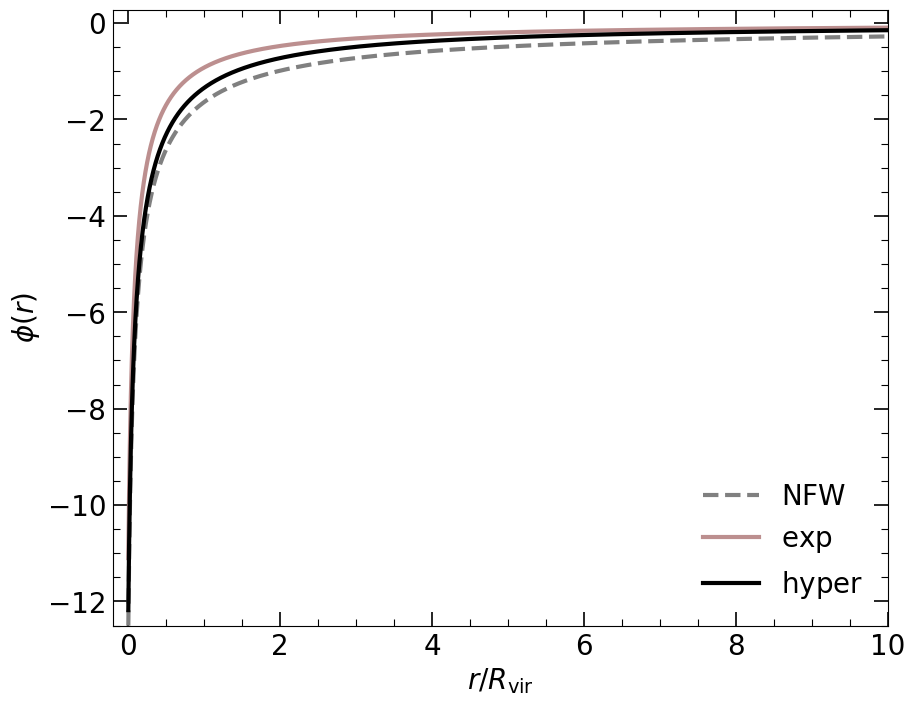

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_xlabel(r"$r/R_\text{vir}$")
ax.set_ylabel(r"$\phi(r)$")

r = np.logspace(-2, np.log10(alpha * R_vir), 10000)
potential_NFW = NFW_potential(r, rho_0, R_s)
potential_exp = my_potential1(r, rho_0, R_s, R_vir)
potential_csch = my_potential2(r, rho_0, R_s, R_vir)

for data, ls, c, lbl in zip([potential_NFW, potential_exp, potential_csch], linestyles, colors, labels):
    ax.plot(r / R_vir, data, linestyle=ls, color=c, label=r'$\text{{{0}}}$'.format(lbl))

ax.legend()

ax.set_ymargin(0.03)
ax.set_ylim(np.min(potential_NFW), ax.get_ylim()[1])
ax.set_xmargin(0.02)
ax.set_xlim(ax.get_xlim()[0], np.max(r) / R_vir)

figures.append(fig)
figure_names.append('potential_comparison')

plt.show()

In [ ]:
save_fig = False

if save_fig:
    for fig, name in zip(figures, figure_names):
        fig.savefig(name, dpi=dpi, bbox_inches='tight')
    
figures = []
figure_names = []

# Distribution Function (DF)

To retrieve the DF, $f(E)$, I used the Eddington Inversion Formula:

$$f(E) = \frac{1}{\sqrt{8} \pi^2} \frac{d}{dE} \int_{r(E)}^\infty \frac{d\rho}{dr} \frac{dr}{\sqrt{\phi(r) - E}}$$

Since my potential is monotonically increasing, the minimum energy is given by $E_{min} = \phi(0)$, and the maximum energy is $E_{max} = \phi(\infty) = 0$. However, since the potential is not defined in $r = 0$ and I can only evaluate it numerically, I set $E_{min} = \phi(\epsilon)$, where $\epsilon$ is a positive arbitrary small number. Moreover, since I can't have an infinite numerical grid, I compute the DF only up to $E_{max} = \phi(\alpha R_{vir})$, where $\alpha$ is a factor of order unity.

The first step for the construction of $f(E)$ is the evaluation of the integral $I(E) = \int_{r(E)}^\infty \frac{d\rho}{dr} \frac{dr}{\sqrt{\phi(r) - E}}$ for every value of $E \in [\phi(\epsilon); \phi(\alpha R_{vir})]$. In order to evaluate the integral I need to know, for every $E$, its lower extreme, i.e. what's the radius that satisfies $\phi(r) = E$. We can achieve this numerically.

After having evaluated the integral we can differentiate it ($\frac{d}{dE} I(E)$) on the same energy grid and divide by $\sqrt{8} \pi^2$ to obtain the DF.

The derivative of the density with respect to the radius is:

$$\frac{d\rho}{dr} = - \rho_0 \frac{\operatorname{csch}(y)}{x(1 + x)^2} \left(\frac{1}{R_s} \frac{y(3x + 1)}{x(1 + x)} + \frac{y \operatorname{coth}(y) - 1}{R_{vir}}\right)$$

where $x = \frac{r}{R_s}$ and $y = \frac{r}{R_{vir}}$.

In [16]:
def my_rho2_derivative(r, rho_0, R_s, R_vir):
    x = r / R_s
    y = r / R_vir
    a = 1 / (np.sinh(y) * x * (1 + x) ** 2)
    b = y * (3 * x + 1) / (x * (1 + x))
    c = y / np.tanh(y) - 1
    return -rho_0 * a * (b / R_s + c / R_vir)

In [17]:
# alpha already defined at the beginning of the notebook
epsilon = 1e-3 # Smaller value might cause problems with the integral or derivative

E_min = my_potential2(epsilon, rho_0, R_s, R_vir, value=True)
# We need more points up to E_mid because the function is very steep
E_mid = my_potential2(epsilon * 50, rho_0, R_s, R_vir, value=True)
E_max = my_potential2(10 * alpha * R_vir, rho_0, R_s, R_vir, value=True)

E_s = my_potential2(R_s, rho_0, R_s, R_vir, value=True)
E_vir = my_potential2(R_vir, rho_0, R_s, R_vir, value=True)
E_limsup = my_potential2(alpha * R_vir, rho_0, R_s, R_vir, value=True)

E_grid = np.concatenate((np.linspace(E_min, E_mid, 2000, endpoint=False), np.linspace(E_mid, E_vir, 1000, endpoint=False), np.linspace(E_vir, E_max, 2000)))

E_min, E_mid, E_max

/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_92050/4072328863.py:6: RuntimeWarning: overflow encountered in sinh
  return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)


(-12.236956499670516, -11.93917062364946, -0.01490033147461229)

In [18]:
# Compute the integral in the Eddington inversion formula for a given enery E
# epsilon is a small number used to avoid the singularity at r = 0
# init is a tuple with the lower and upper bounds for the root.
def eddington_integral(E, rho_0, R_s, R_vir, init):
    if not np.iterable(E):
        r_inf = find_root(lambda r: my_potential2(r, rho_0, R_s, R_vir, value=True) - E, init)
        return quad(lambda r: my_rho2_derivative(r, rho_0, R_s, R_vir) / (my_potential2(r, rho_0, R_s, R_vir, value=True) - E) ** 0.5,
                    r_inf.x, np.inf)[0]
    else:
        R_inf = [find_root(lambda r: my_potential2(r, rho_0, R_s, R_vir, value=True) - e, init) for e in tqdm(E, desc="Inverting potential")]
        return np.array([quad(lambda r: my_rho2_derivative(r, rho_0, R_s, R_vir) / (my_potential2(r, rho_0, R_s, R_vir, value=True) - e) ** 0.5,
                              r_inf.x, np.inf)[0] for e, r_inf in tqdm(zip(E, R_inf), total=len(E), desc="Computing integral")])
    
def DF(E, rho_0, R_s, R_vir, init, h=1e-5):
    I_E = (eddington_integral(E + h, rho_0, R_s, R_vir, init) - eddington_integral(E - h, rho_0, R_s, R_vir, init)) / (2 * h)
    return I_E / (np.pi ** 2 * 8 ** 0.5)

In [19]:
I_E = eddington_integral(E_grid, rho_0, R_s, R_vir, init=(0.9 * epsilon, 10.1 * alpha * R_vir))

Inverting potential:   0%|          | 0/5000 [00:00<?, ?it/s]/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_92050/4072328863.py:6: RuntimeWarning: overflow encountered in sinh
  return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)
Computing integral: 100%|██████████| 5000/5000 [16:44<00:00,  4.98it/s]


In [20]:
f_E = np.gradient(I_E, E_grid) / (np.pi ** 2 * 8 ** 0.5)

In [21]:
E_grid_test = np.concatenate((np.linspace(E_min, E_mid, 1300, endpoint=False), np.linspace(E_mid, E_vir, 700, endpoint=False), np.linspace(E_vir, E_max, 1300)))
I_E_test = eddington_integral(E_grid_test, rho_0, R_s, R_vir, init=(0.9 * epsilon, 10.1 * alpha * R_vir))

Inverting potential:   0%|          | 0/3300 [00:00<?, ?it/s]/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_92050/4072328863.py:6: RuntimeWarning: overflow encountered in sinh
  return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)
Computing integral: 100%|██████████| 3300/3300 [10:50<00:00,  5.08it/s]


In [22]:
f_E_test = np.gradient(I_E_test, E_grid_test) / (np.pi ** 2 * 8 ** 0.5)

In [23]:
# epsilon = 1e-3; E_mid = epsilon * 50; gamma = 6; alpha = 0.01; 1000 + 1000 points

kr = KernelRidge(alpha=0.01, kernel='laplacian', gamma=6)
kr.fit(E_grid[:, np.newaxis], f_E)

# Note that since the DF is obtained by differentiating on the numerical grid
# used to compute the integral, the fitted estimator accuracy depends on both
# the training and test set numerical grid densities. This mean that if you fit on
# a dense grid but then test on DF values obtained from a non dense enough grid,
# the estimator might perform poorly.

KernelRidge(alpha=0.01, gamma=6, kernel='laplacian')

Score: 0.9990028784421753


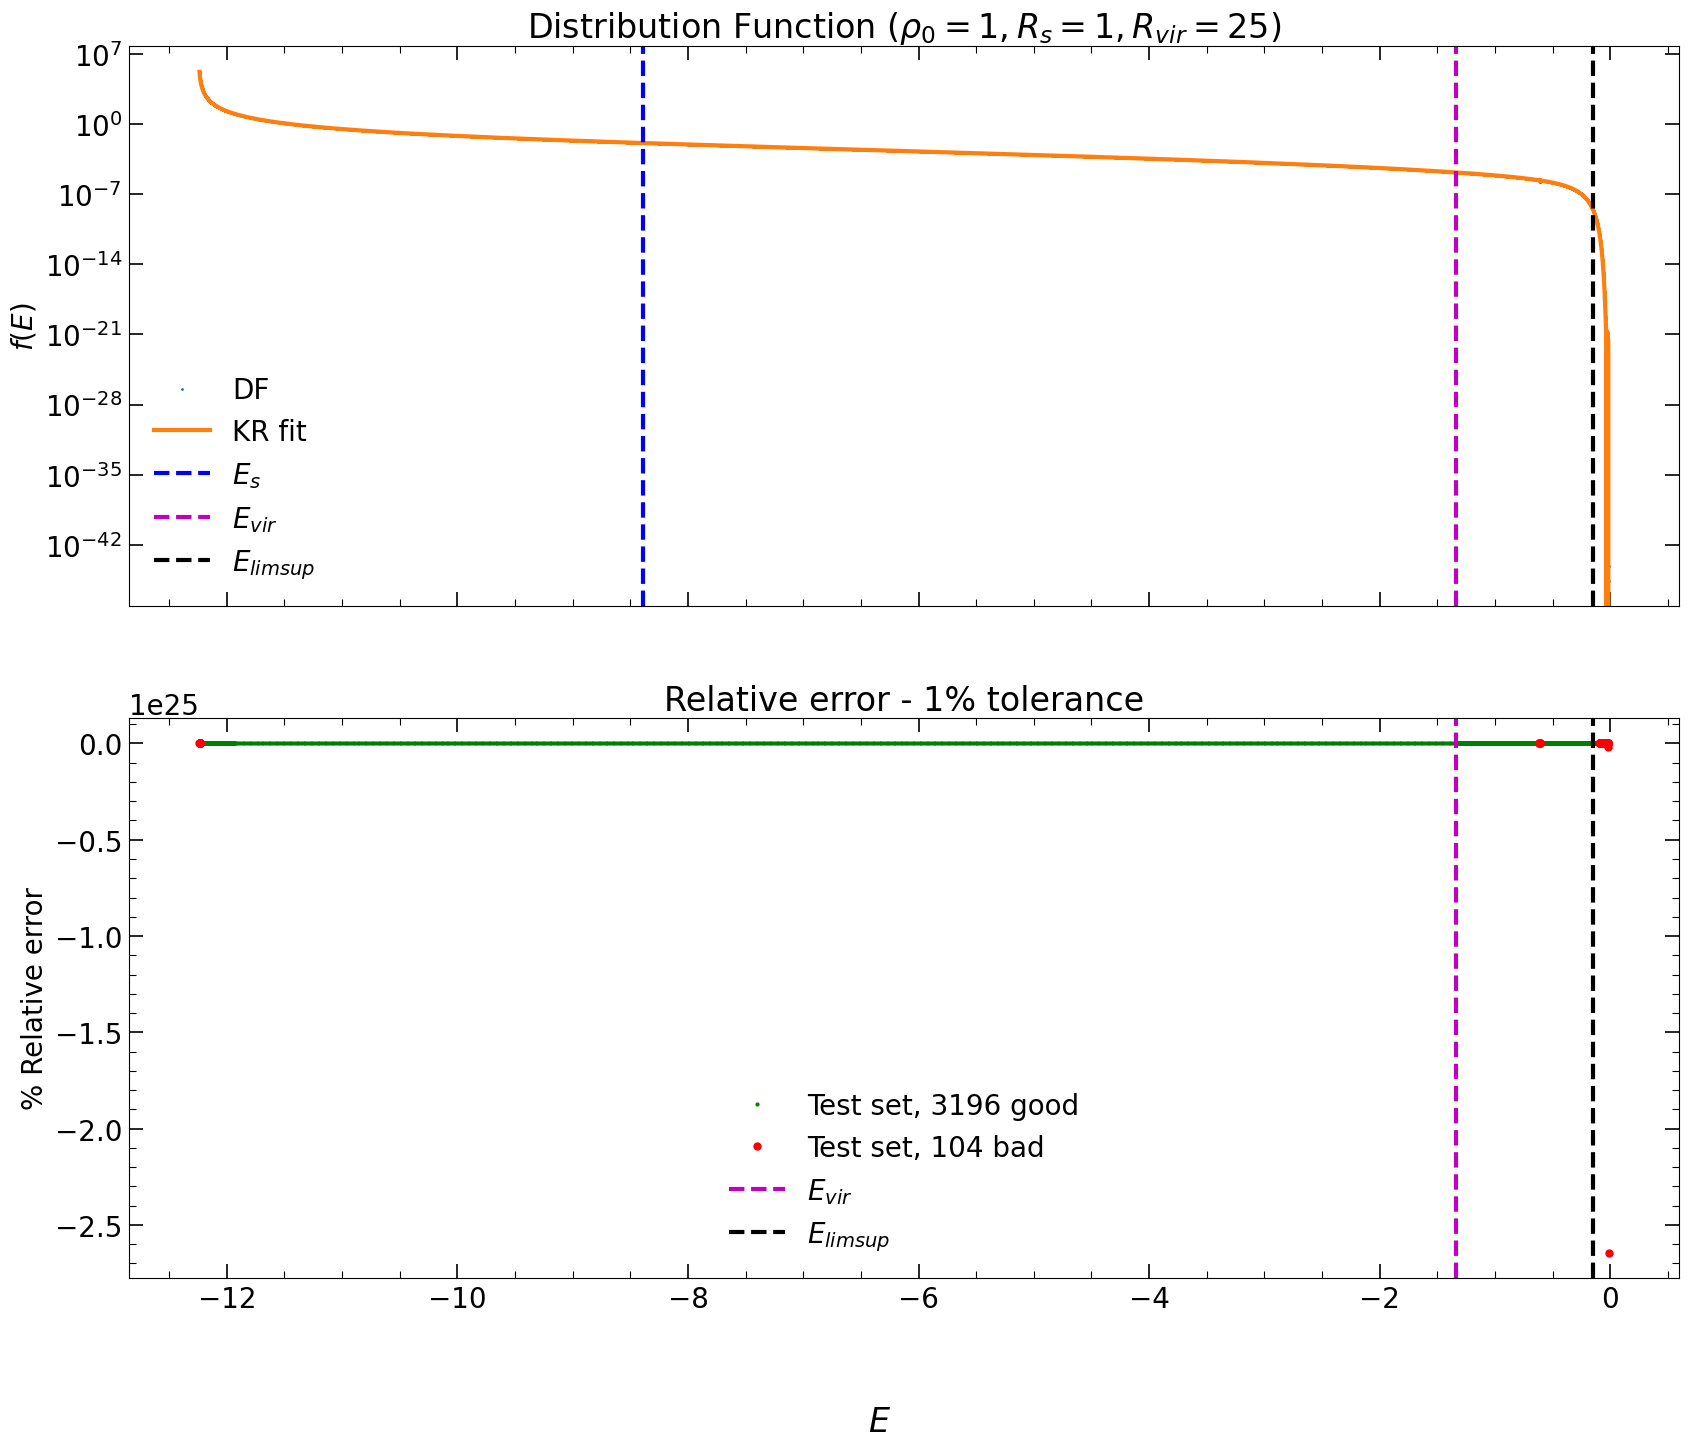

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(20, 16), sharex=True)

fig.supxlabel(r"$E$")

ax[0].set_title("Distribution Function " + r"($\rho_0 = {0}, R_s = {1}, R_{{vir}} = {2}$)".format(rho_0, R_s, R_vir))
ax[0].set_ylabel(r"$f(E)$")

ax[0].plot(E_grid, f_E, label="DF", marker='o', markersize=1, linestyle='')
ax[0].plot(E_grid_test, kr.predict(E_grid_test[:, np.newaxis]), label="KR fit", marker='o', markersize=1)

ax[0].axvline(E_s, color='b', linestyle='--', label=r"$E_{s}$")
ax[0].axvline(E_vir, color='m', linestyle='--', label=r"$E_{vir}$")
ax[0].axvline(E_limsup, color='k', linestyle='--', label=r"$E_{limsup}$")

ax[0].set_yscale('log')

# ax[0].set_xlim(1.02 * E_min, E_vir + 1)
# ax[0].set_ylim(-5, 1.1 * max(f_E))

# ax[0].set_xlim(1.001 * E_min, -12.15)
# ax[0].set_xlim(-11.96, -11.92)
# ax[0].set_xlim(-0.625, -0.6)

# ax[0].set_ylim(10, 15)

tol = 1
ax[1].set_title("Relative error - {0}% tolerance".format(tol))
ax[1].set_ylabel(r"% Relative error")

good_mask = abs(100 * (f_E_test - kr.predict(E_grid_test[:, np.newaxis])) / f_E_test) < tol
ax[1].plot(E_grid_test[good_mask], 100 * (kr.predict(E_grid_test[good_mask, np.newaxis]) - f_E_test[good_mask]) / f_E_test[good_mask], label="Test set, {0} good".format(sum(good_mask)), color='g', marker='o', markersize=2, linestyle='')
ax[1].plot(E_grid_test[~good_mask], 100 * (kr.predict(E_grid_test[~good_mask, np.newaxis]) - f_E_test[~good_mask]) / f_E_test[~good_mask], label="Test set, {0} bad".format(sum(~good_mask)), color='r', marker='o', markersize=5, linestyle='')

# ax[1].plot(E_grid, 100 * (f_E - gpr.predict(E_grid[:, np.newaxis])) / f_E, label="Training set")
ax[1].axvline(E_vir, color='m', linestyle='--', label=r"$E_{vir}$")
ax[1].axvline(E_limsup, color='k', linestyle='--', label=r"$E_{limsup}$")

# ax[1].set_ylim(-0.1, 10)

ax[0].legend()
ax[1].legend(loc='lower center')

print("Score:", kr.score(E_grid_test[:, np.newaxis], f_E_test))

plt.show()

In [25]:
E_plot_grid = np.linspace(E_min, E_limsup, 1000)
f_E_plot = DF(E_plot_grid, rho_0, R_s, R_vir, init=(0.9 * epsilon, 10.1 * alpha * R_vir))

Inverting potential:   0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_92050/4072328863.py:6: RuntimeWarning: overflow encountered in sinh
  return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)
Computing integral: 100%|██████████| 1000/1000 [03:32<00:00,  4.72it/s]


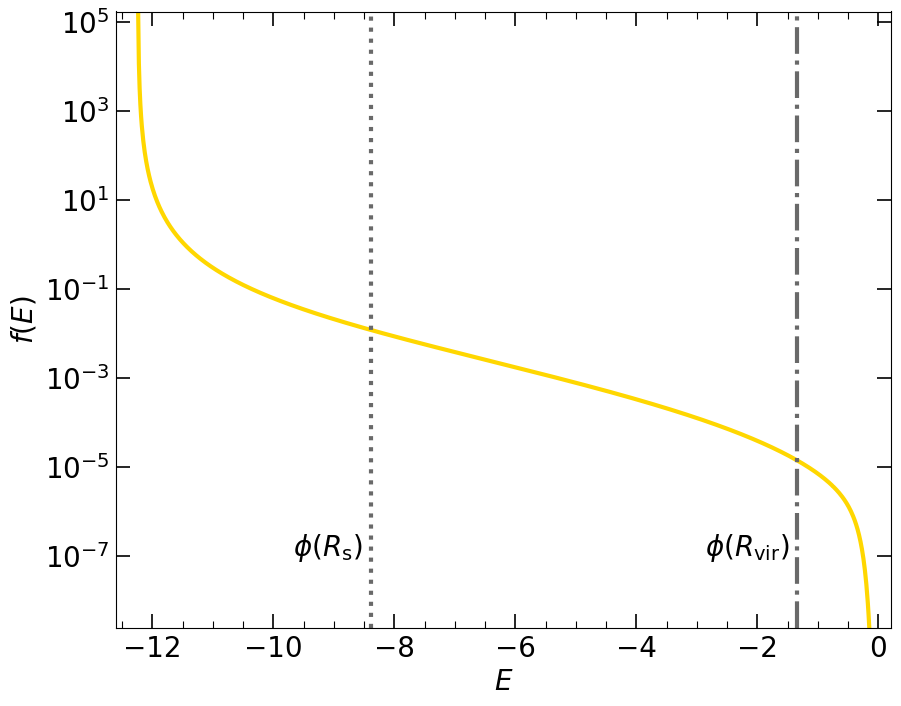

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_xlabel(r'$E$')
ax.set_ylabel(r'$f(E)$')

ax.plot(E_plot_grid, f_E_plot, label="DF", color='gold')

v_lines_text_2 = [r'$\phi(R_\text{s})$', r'$\phi(R_\text{vir})$']

for val, text, ls in zip(np.array([E_s, E_vir]), v_lines_text_2, v_lines_styles):
    ax.axvline(val, color=v_lines_color, linestyle=ls)
    ax.text(val - (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.01, 1e-7, text, horizontalalignment='right')
    ax.transScale

ax.set_yscale('log')

ax.autoscale(axis='y', tight=True)
ax.set_xmargin(0.03)

figures.append(fig)
figure_names.append('DF')

plt.show()

In [68]:
r_test = np.logspace(-2, np.log10(alpha * R_vir), 2000)
pot_test = [my_potential2(r, rho_0, R_s, R_vir, value=True) for r in r_test]

/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_92050/4072328863.py:6: RuntimeWarning: overflow encountered in sinh
  return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)


In [69]:
# Catch warnings (print statements are very expensive)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    rho_DF = 4 * np.pi * np.array([quad(lambda x: float(kr.predict([[0.5 * x ** 2 + pot]])[0]) * x ** 2, 0, (-2 * pot) ** 0.5)[0]
                                   for pot in tqdm(pot_test)])

100%|██████████| 2000/2000 [27:32<00:00,  1.21it/s] 


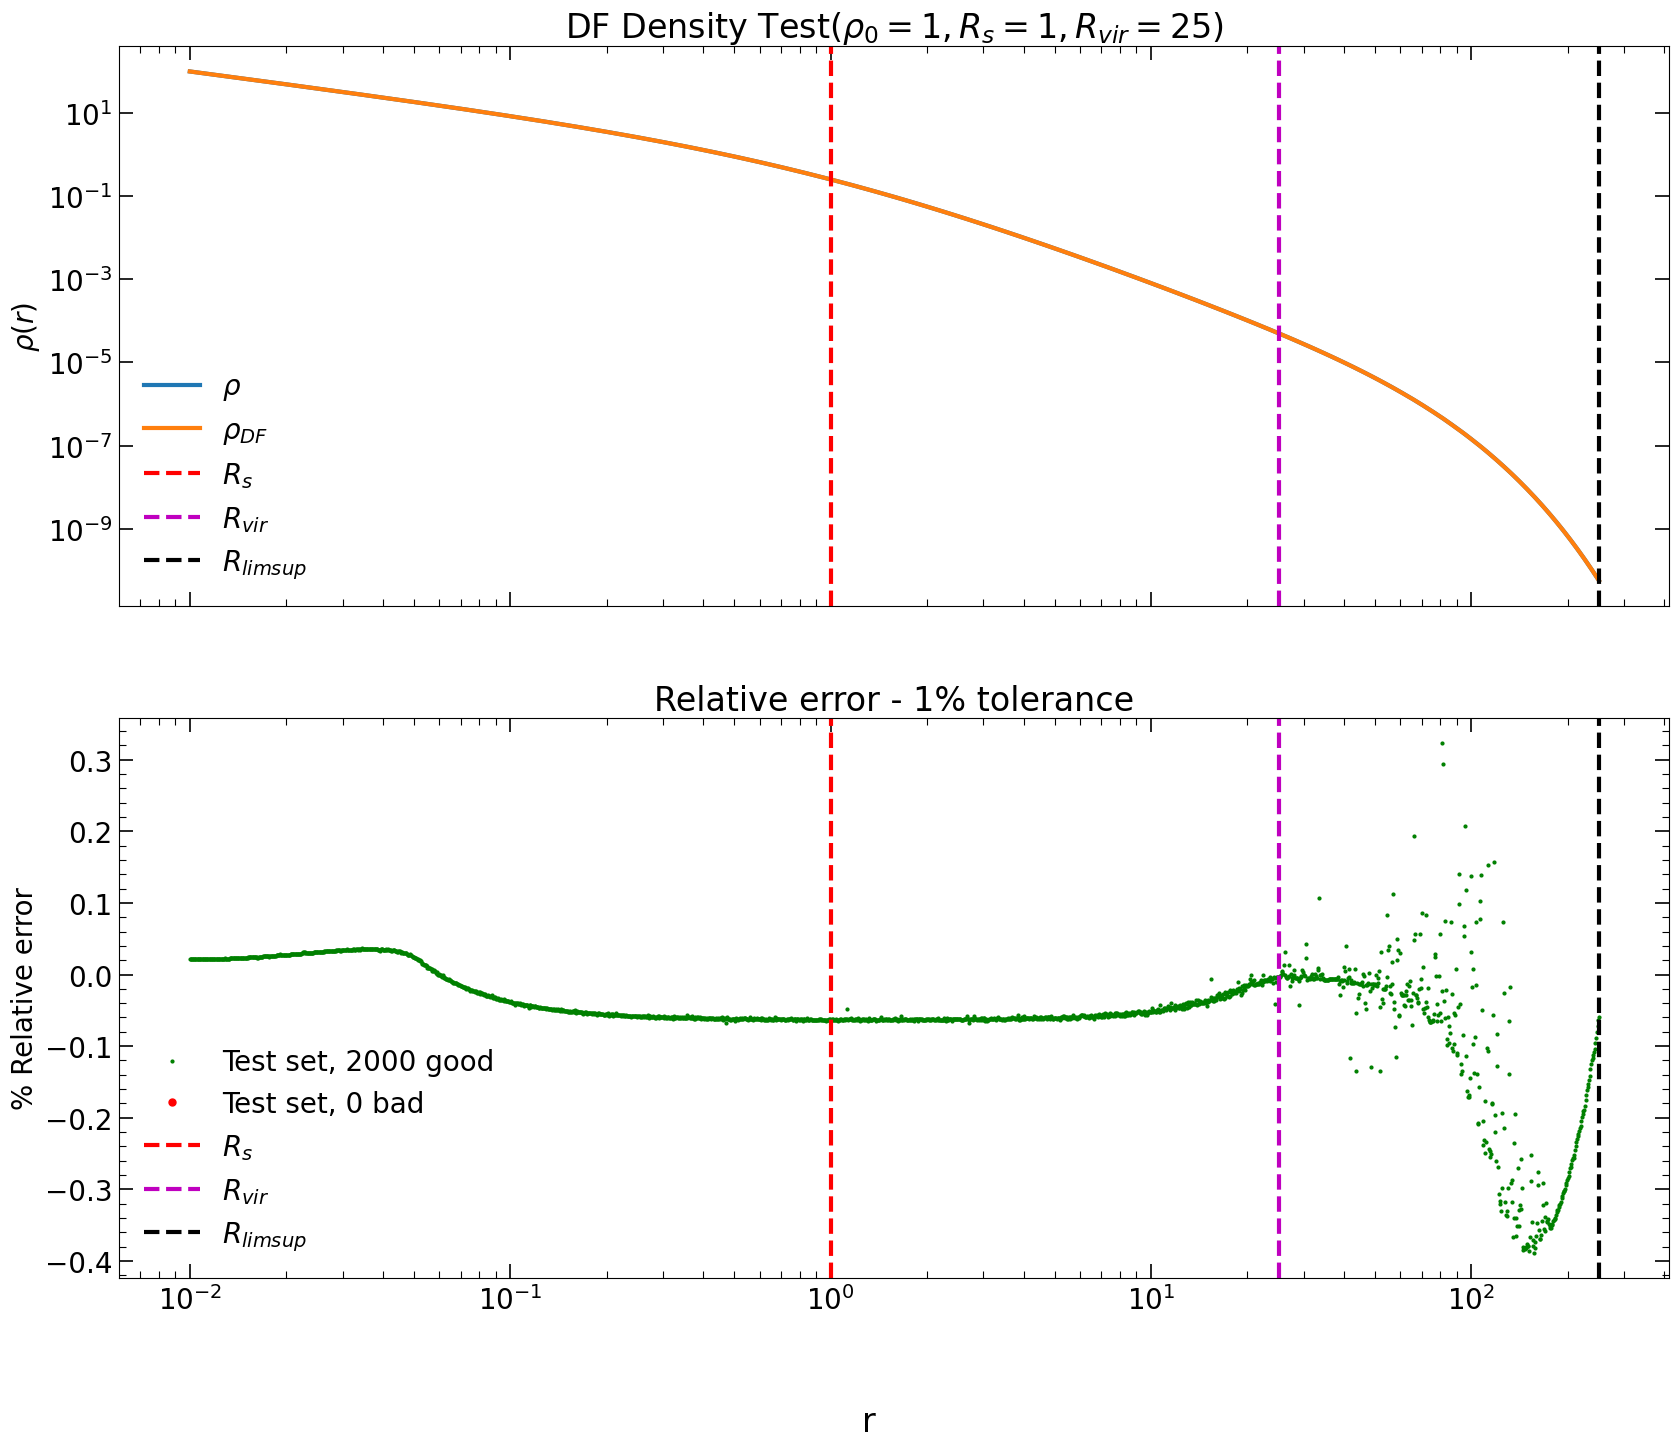

In [70]:
fig, ax = plt.subplots(2, 1, figsize=(20, 16), sharex=True)

fig.supxlabel(r"r")

ax[0].set_title("DF Density Test" + r"($\rho_0 = {0}, R_s = {1}, R_{{vir}} = {2}$)".format(rho_0, R_s, R_vir))
ax[0].set_ylabel(r"$\rho(r)$")
ax[0].loglog()

ax[0].plot(r_test, my_rho2(r_test, rho_0, R_s, R_vir), label=r"$\rho$")
ax[0].plot(r_test, rho_DF, label=r"$\rho_{DF}$")
ax[0].axvline(R_s, color='r', linestyle='--', label=r"$R_s$")
ax[0].axvline(R_vir, color='m', linestyle='--', label=r"$R_{vir}$")
ax[0].axvline(alpha * R_vir, color='k', linestyle='--', label=r"$R_{limsup}$")

tol = 1
ax[1].set_title("Relative error - {0}% tolerance".format(tol))
ax[1].set_ylabel(r"% Relative error")

good_mask = abs(100 * (rho_DF - my_rho2(r_test, rho_0, R_s, R_vir)) / my_rho2(r_test, rho_0, R_s, R_vir)) < tol
ax[1].plot(r_test[good_mask], 100 * (rho_DF[good_mask] - my_rho2(r_test, rho_0, R_s, R_vir)[good_mask]) / my_rho2(r_test, rho_0, R_s, R_vir)[good_mask], label="Test set, {0} good".format(sum(good_mask)), color='g', marker='o', markersize=2, linestyle='')
ax[1].plot(r_test[~good_mask], 100 * (rho_DF[~good_mask] - my_rho2(r_test, rho_0, R_s, R_vir)[~good_mask]) / my_rho2(r_test, rho_0, R_s, R_vir)[~good_mask], label="Test set, {0} bad".format(sum(~good_mask)), color='r', marker='o', markersize=5, linestyle='')

ax[1].axvline(R_s, color='r', linestyle='--', label=r"$R_s$")
ax[1].axvline(R_vir, color='m', linestyle='--', label=r"$R_{vir}$")
ax[1].axvline(alpha * R_vir, color='k', linestyle='--', label=r"$R_{limsup}$")

ax[0].legend()
ax[1].legend()

plt.show()

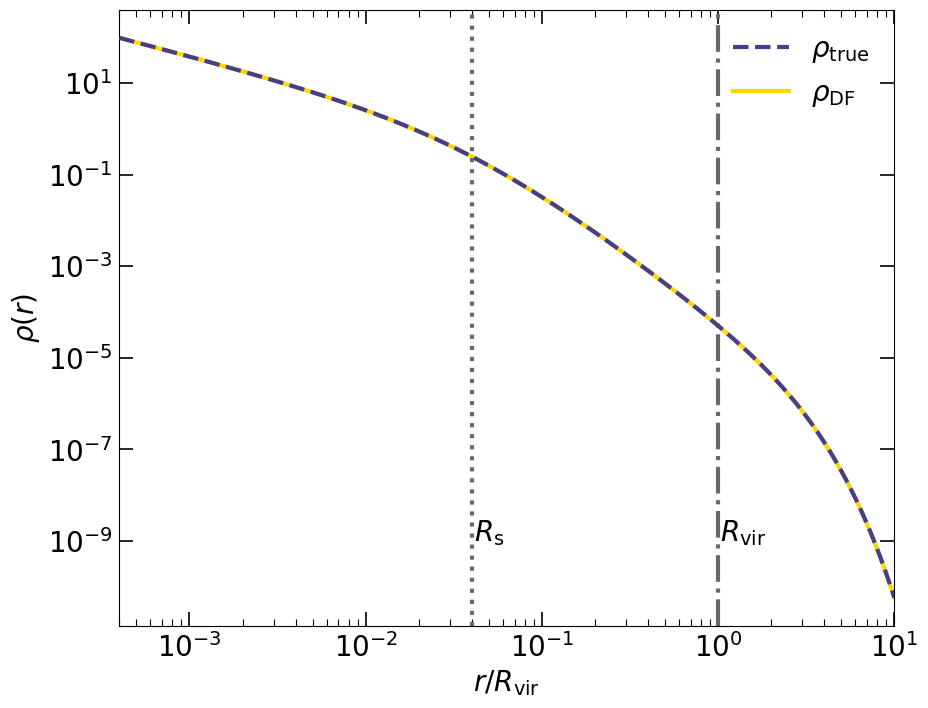

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_xlabel(r"$r/R_\text{vir}$")
ax.set_ylabel(r"$\rho(r)$")
ax.loglog()

ax.plot(r / R_vir, rho_csch, color='darkslateblue', linestyle='--', label=r'$\rho_\text{true}$', zorder=3)
ax.plot(r_test / R_vir, rho_DF, color='gold', label=r"$\rho_\text{DF}$")

for val, text, ls in zip(np.array([R_s, R_vir]) / R_vir, v_lines_text, v_lines_styles):
    ax.axvline(val, color=v_lines_color, linestyle=ls)
    ax.text(val * 1.03, 1e-9, text)

ax.legend()

ax.autoscale(axis='x', tight='True')

figures.append(fig)
figure_names.append('DF_rho')

plt.show()

In [108]:
save_fig = False

if save_fig:
    for fig, name in zip(figures, figure_names):
        fig.savefig(name, dpi=dpi, bbox_inches='tight')
    
figures = []
figure_names = []

In [72]:
save_model = False

if save_model:
    with open("DF_model.pkl", "wb") as f:
        pickle.dump(kr, f)